# Train a Machine Learning Model
Determine the optimal machine learning algorithm and train it.

In [1]:
%matplotlib inline
import sys
from glob import glob
sys.path = glob('/projects/CSC249ADCD01/packages/*') + sys.path
from copy import deepcopy
from glob import glob
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import stats
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, cross_val_predict, RepeatedKFold, GridSearchCV
from sklearn.linear_model import BayesianRidge, LinearRegression, Lasso, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from stopping_power_ml.io import load_qbox_data
import pandas as pd
import numpy as np
import pickle as pkl
import os

In [2]:
import warnings; warnings.simplefilter('ignore')

Load Parsl

In [3]:
import parsl
from parsl import *
#from parsl_config import config
workers = IPyParallelExecutor()
dfk = DataFlowKernel(executors=[workers])
print("Parsl version : ", parsl.__version__)

Executors :  {0: <IPP Executor for site:Static_IPP>}
Parsl version :  0.3.1


## Load in the Dataset
This was created by a different notebook

In [4]:
data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz'))
print('Data set size:', len(data))

Data set size: 9800


Remove the initial transient

In [5]:
data.query('initial == False', inplace=True)
print('Training set size:', len(data))

Training set size: 9379


Determine which columns are inputs

In [9]:
featurizers = pkl.load(open(os.path.join('..', 'featurizers.pkl'), 'rb'))[:-1]

In [10]:
X_cols = sum([x.feature_labels() for x in featurizers], [])

In [11]:
y_col = 'force'

## Test out Some ML Models
Trying out various differentiable ML algorithms:

- `DummyRegressor`: A model that returns the mean of the training set for all predictions
- `BayesianRidge`: Ridge regression that sets the hyperparameters using Bayesian statistics
- `Lasso`: Sparse linear model, fast to train
- `LinearRegression`: Just Ordinary Least Squares

Also throw in some feature expansion and feature selection

### Create Testing Routine
What we want to know whether a model trained on the beginning of a simulation can successfully predict forces at the end of the simulation.

In [12]:
@App('python', dfk)
def test_on_first_part(model, data, max_step, X_cols=X_cols, y_col=y_col):
    """Train a model only using the first part of a dataset, test it
    
    :param model: model to be tested
    :param data: dataset used for training
    :param max_step: int, maximum timestep. All data before this timestep will be used for training
    :return:
        - train_size: Number of training points
        - average_force: Average force 
        - trajectory: Force as a function of timestep"""
    import numpy as np
    # Train model on all timesteps before current
    train_data = data.query('timestep <= %d'%max_step)
    model.fit(train_data[X_cols], train_data[y_col])

    # Predict on all timesteps
    traj = model.predict(data[X_cols])

    # Store results
    return len(train_data), np.mean(traj), traj

In [13]:
def train_over_time(model, data, steps=None):
    """Train the model on increasingly-larger amounts of data
    
    :param model: model to be tested
    :param data: training/test data
    :param steps: increments to test at. Model is trained at all entries before this timestep
    :return: Several lists:
        - train_size: Number of training points
        - average_force: Average force (i.e., stopping power) 
        - trajectory: Full trajectory
        - step: timestep
    """
    
    # Get the default steps
    if steps is None:
        steps = np.linspace(data['timestep'].min(), data['timestep'].max(), 31, dtype=np.int)[1:]
        
    # Test the models
    futures = [test_on_first_part(deepcopy(model), data, step) for step in steps]
    train_size, mean_forces, trajs = zip(*[f.result() for f in futures])    
    return train_size, mean_forces, trajs, steps

In [14]:
test_results = dict()
def run_tests(model, name, verbose=False):
    """Evaluate a model, store results in test_results variable
    
    :param model: model to test
    :param name: name of results to store"""
        
    # Increase time CV
    step, mean_forces, traj, steps = train_over_time(model, data)
    
    if verbose:
        print('Model: %s - Stopping power after half simulation: predicted=%.2f actual=%.2f'%(name,
                                                                                              mean_forces[int(len(mean_forces)/2)],                                                                                 data[y_col].mean()))
        
    # Train model on whole dataset
    model.fit(data[X_cols], data[y_col])
    
    test_results[name] = {
        'over_time': {'training_size': step, 'mean_force': mean_forces, 'traj': traj, 'step':steps},
        'model': deepcopy(model.best_estimator_ if isinstance(model, GridSearchCV) else model)
    }

### Run a dummy model
Get a "non-ML" baseline

In [15]:
model = DummyRegressor()

In [16]:
%%time
run_tests(model, 'dummy', True)

Model: dummy - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 5.85 s


### Test Bayesian Ridge


In [17]:
model = BayesianRidge()

In [18]:
%%time
run_tests(model, 'bayes', True)

Model: bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 6.04 s


### Test Bayesian Ridge w/ Poly Features

In [19]:
model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('model', BayesianRidge())
])

In [20]:
%%time
run_tests(model, 'bayes_poly', True)

Model: bayes_poly - Stopping power after half simulation: predicted=0.23 actual=0.24
Wall time: 14.9 s


### Lasso

In [21]:
model = GridSearchCV(Lasso(normalize=True, max_iter=5000, fit_intercept=True), {'alpha':np.logspace(-7,-1,20)}, cv=2)

In [22]:
%%time
run_tests(model, 'lasso', True)

Model: lasso - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 29.7 s


### Lasso+BayesianRidge

In [23]:
model = GridSearchCV(Pipeline([
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=22, fit_intercept=True, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(5,30)})

In [24]:
%%time
run_tests(model, 'lasso+bayes', True)

Model: lasso+bayes - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 22.1 s


### Test Bayesian Ridge w/ Poly Features

In [25]:
model = GridSearchCV(Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('lasso_rfe', SelectFromModel(
        LassoLars(normalize=True, max_iter=35, fit_intercept=True, alpha=1e-10))
    ),
    ('model', BayesianRidge())
]), {'lasso_rfe__estimator__max_iter':range(5,30)})

In [26]:
%%time
run_tests(model, 'lasso+bayes_poly', True)

Model: lasso+bayes_poly - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 1min 4s


Print the chosen settings

In [27]:
print(test_results['lasso+bayes_poly']['model'])

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('lasso_rfe', SelectFromModel(estimator=LassoLars(alpha=1e-10, copy_X=True, eps=2.220446049250313e-16,
     fit_intercept=True, fit_path=True, max_iter=24, normalize=True,
     positive=False, precompute='auto'...rue, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False))])


### Test Ordinary Least Squares

In [28]:
model = LinearRegression()

In [29]:
%%time
run_tests(model, 'ols', True)

Model: ols - Stopping power after half simulation: predicted=0.24 actual=0.24
Wall time: 5.75 s


## Determine the best algorithm
As the force acting on a particle varies by several orders of magnitude and changes sign, I will use the Spearman's correlation coefficient to determine the optimal algorithm. Usually, I like to use MAE. Given the large range of forces, small variations in the very large forces have a greater impact on the MAE than relatively similar changes on the small forces. I could also use the MRE or fit to the log of the error, but the sign change makes those routes impractical. So, I choose the Spearman's correlation coefficient 

In [30]:
num_tests = len(test_results['ols']['over_time']['traj'])

In [31]:
experiment_number = int(num_tests * 0.5)

train_size = test_results['lasso']['over_time']['training_size'][experiment_number]
print('Training set size: ', train_size)
results = dict([
    (name, {'force_mae': np.abs(data[y_col][train_size:] - my_data['over_time']['traj'][experiment_number][train_size:]).mean(),
            'force_spearman': stats.spearmanr(data[y_col][train_size:],
                                              my_data['over_time']['traj'][experiment_number][train_size:])[0]})
    for name, my_data in test_results.items()
])
del results['dummy']
over_time_results = pd.DataFrame(results).T
over_time_results.sort_values('force_spearman', ascending=False, inplace=True)
over_time_results

Training set size:  5002


,force_mae,force_spearman
lasso+bayes_poly,0.024188,0.994375
ols,0.025287,0.994250
bayes,0.025388,0.994211
lasso+bayes,0.040042,0.991495
lasso,0.053890,0.988808
bayes_poly,0.038079,0.985512


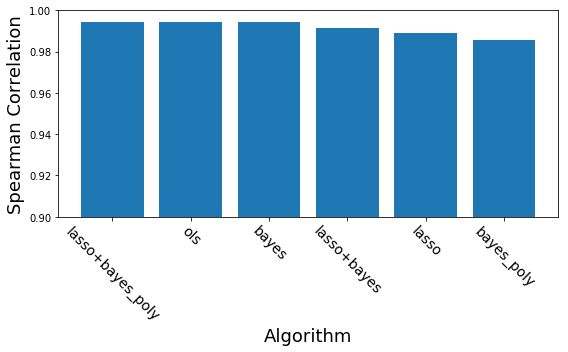

In [32]:
fig, ax = plt.subplots()

ax.bar(range(len(over_time_results)), over_time_results['force_spearman'])

ax.set_xticks(range(len(over_time_results)))
ax.set_xticklabels(list(over_time_results.index), fontsize=14, rotation=-45);

ax.set_ylim(0.9, 1)
ax.set_ylabel('Spearman Correlation', fontsize=18)
ax.set_xlabel('Algorithm', fontsize=18)

fig.set_size_inches(8, 5)
fig.tight_layout()

Select the best model

In [33]:
best_model = over_time_results.index[0]
print('Best model:', best_model)

Best model: lasso+bayes_poly


## Plot just the best one
Show the model performance

In [34]:
best_results = test_results['lasso+bayes_poly'] # This fits the data the best at large training set sizes

In [35]:
pkl.dump(best_results['model'], open('best_model.pkl', 'wb'))

Plot how well the algorithm forecasts stopping force

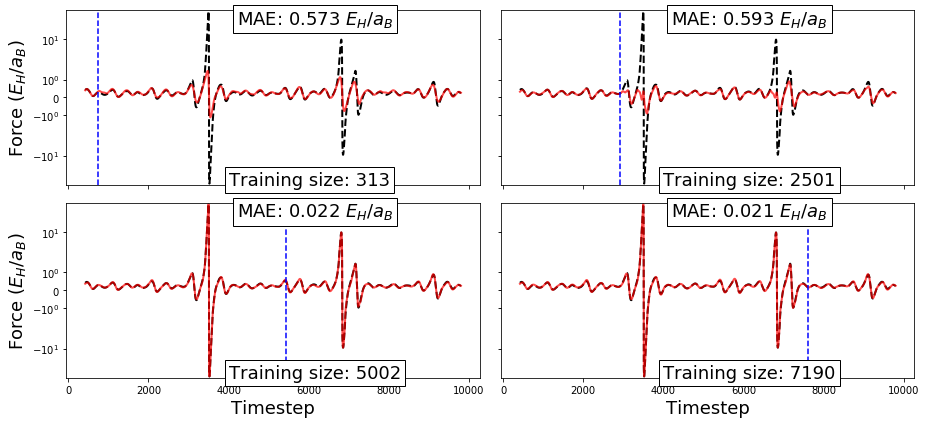

In [36]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)


for f,ax in zip([0,int(0.25*num_tests),int(0.5*num_tests),int(0.75*num_tests)],axs.flatten()):
    
    ax.plot(data['timestep'], data['force'], 'k--', lw=2)
    ax.set_ylim(ax.get_ylim()) # Make sure the scales stay appropriate
    
    traj = best_results['over_time']['traj'][f]
    ax.plot(data['timestep'], traj, 'r-', alpha=0.7, lw=2)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(4200, 30, 'MAE: %.3f $E_H/a_B$'%traj_error, fontsize=18,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.text(4000, -80, 'Training size: %d'%best_results['over_time']['training_size'][f],
            fontsize=18,
           bbox=dict(edgecolor='k', facecolor='w'))
    
    ax.plot([best_results['over_time']['step'][f],]*2, ax.get_ylim(), 'b--')
    
    ax.set_yscale('symlog')

axs[1,0].set_xlabel('Timestep', fontsize=18)
axs[1,1].set_xlabel('Timestep', fontsize=18)
axs[0,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)
axs[1,0].set_ylabel('Force ($E_H/a_B$)', fontsize=18)

fig.set_size_inches(13,6)
fig.tight_layout()

The above figure shows the fitness of the model as a function of training set size. In each frame, the model is trained on the data to the left of the blue, vertical line. The predictions of the model are shown in red and the TD-DFT result in black. After we've trained the model on half of the dataset (bottom left), the model fits the entire trajectory very well. At this point, we could stop the TD-DFT simulation and, instead, use our ML surrogate to compute the stopping power. By using the surrogate instead, we would get the same result as TD-DFT with only half of the computational expense.

## Make it an animation

In [37]:
frames = np.linspace(1, len(data) / 2, 100, dtype=np.int)

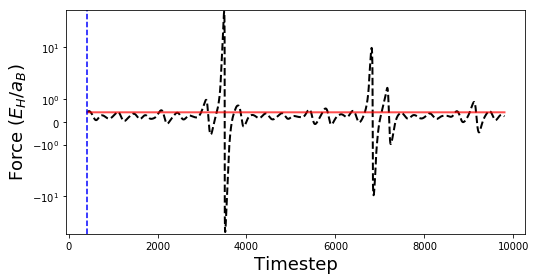

In [38]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force'], 'k--', lw=2)

model.fit(data[X_cols].iloc[:1], data[y_col].iloc[:1])
lne, = ax.plot(data['timestep'], model.predict(data[X_cols]), 'r-', alpha=0.7, lw=2)
ax.set_ylim(ax.get_ylim())
bar, = ax.plot([data['timestep'].iloc[:1].max(),]*2, ax.get_ylim(), 'b--')

def update(frame):
    size = frames[frame]
    model.fit(data[X_cols].iloc[:size], data[y_col].iloc[:size])
    lne.set_data(data['timestep'], model.predict(data[X_cols]))
    
    bar.set_data([data['timestep'].iloc[:size].max(),]*2, ax.get_ylim())
    return lne, bar
    
anim = FuncAnimation(fig, update, frames=len(frames), interval=100, blit=True)

ax.set_yscale('symlog')
ax.set_xlabel('Timestep', fontsize=18)
ax.set_ylabel('Force ($E_H/a_B$)', fontsize=18)
fig.tight_layout()
fig.set_size_inches(8, 4)

In [39]:
HTML(anim.to_html5_video())

This video shows the changes in the fitness of the model as we add new training data. In each frame, the model is trained using all of the data to the left of the blue bar. The black line is the TD-DFT result and the red line in the ML prediction. Notice how the model first starts to accurately predict the stopping power in low-force region and then accurately models the high force regions. After we gather about half of the training data, our model predictions no longer fluctuate with adding more data. 

In [40]:
anim.save(os.path.join('figures', 'training-animation.mp4'), dpi=330, writer='ffmpeg')

In [41]:
dfk.cleanup()